# Laboratoire 1 : Extraction de primitives
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | ahmad al-taher - alta22109307                           |
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | automn 2018                                             |
| Groupe                | 2                                                       |
| Numéro du laboratoire | 00                                                      |
| Professeur            | Hervé Lombaert                                          |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 20 sep 2018                                             |

In [2]:
import numpy as np
import cv2
from scipy.misc import imread, imshow,face
import matplotlib.pyplot as plt


In [3]:
import numpy, math
import cv2 as cv
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

class Image:
    def __init__(self, path,label, answer):
        """
             The only construct is to build an object type image that has all the elements required to make a decision weather it is
             a smooth or spiral galaxy
             
             Args:
                 self : refers to the class
                 path : Where the image is stored
                 label : The image name 
                 answer : The final answer (smooth or spiral). This is the answer from the data set. 
                          It is used to verify after making a decision. 
                          
              Returns:
                  An Image object with the image manipulations
         """
        self.Path = path
        self.Label = label
        self.Answer = answer
        self.Pixels = numpy.array(cv2.imread(path))
        self.Width = self.Pixels.shape[0]
        self.Hight = self.Pixels.shape[1]
        #we will always use the cropped image
        #default crop is 250
        self.crop(250)
        #useful image manipulations
        self.manipulations()
        #default computations
        self.ComputeCircularity()
        self.computeBlackWhite()
        
    def manipulations(self):
        """
             This method is used to apply all the images manipulation on the image. Such as grayscale.
             Cropped image is the default image used 
             
             Args:
                 self: refers to the class
        """
        #remove noise by blurring with a Gaussian filter
        self.CroppedPixels = cv.GaussianBlur(self.CroppedPixels,(3,3), 0)
        #convert to grayscale
        self.GrayScale = cv.cvtColor(self.CroppedPixels, cv.COLOR_BGR2GRAY)
        """remove background noise
        #the result is worst with laplacian
        #laplacian = cv.Laplacian(self._GrayScale, cv.CV_16S, 3)
        #laplacian = cv.convertScaleAbs(laplacian)
        #self._GrayScale = self._GrayScale - laplacian 
        """
        self.Threshold = threshold_otsu(self.GrayScale)
        self.Binary = self.GrayScale > self.Threshold
    
    def crop(self, dimentions):
        """
             This method is used to apply a crop to the image. Since the image is squared only on parameter is required 
             
             Args:
                 dimentions: refers the final demention of the image. Such as the final image would have
                                 dimentions*dimentions. Ex: dimentions=250 the image will be 250x250
        """
        # dimention is the width and hight to crop to. Since it is a square.
        upper_width = int(self.Width/2 + dimentions/2)
        lower_width = int(self.Width/2 - dimentions/2)
        upper_height = int(self.Hight/2 + dimentions/2)
        lower_height = int(self.Hight/2 - dimentions/2)
        #new array of the image
        self.CroppedPixels = self.Pixels[ lower_width:upper_width,lower_height : upper_height]
        
    def computeBlackWhite(self):
        """
             This method is used to compute the black and white ratio.
             The formula is blacks / whites
             
             Args:
                 self: refers to the class
        """
        self.Black = 0
        self.White = 0
        self.BlackWhiteRatio = 0
        #compute the # of black and the # of whites
        for row in self.Binary :
            for pixel in row:
                if(pixel):
                    self.White += 1
                else:
                    self.Black += 1
        #compute the B/W ratio
        if self.Black > 0 and self.White >0 :
            self.BlackWhiteRatio = self.Black / self.White
        
    def ComputeCircularity(self):
        """
             This method is used to compute the circularity of the galaxy.
             The formula used is : 𝐶 = 4 ∗ 𝜋 ∗ 𝐴/𝑃2
             
             Args:
                 self: refers to the class
         """
        #example from openCV documentation
        ret,thresh = cv.threshold(self.GrayScale,self.Threshold, 255, 0)
        img, contours, hierarchy = cv.findContours(thresh,1 ,2 )
        cnt= contours[0]
        
        self.area = cv.contourArea(cnt)
        self.perimeter = cv.arcLength(cnt,True)
        #circularity
        self.C = 0
        if self.area >0 and self.perimeter > 0 :
            self.C = 4* math.pi * self.area/ math.pow(self.perimeter,2)

In [60]:
import matplotlib.pyplot as plt
import math

def loadAllImages(dataPath , imageFolderPath):
    """
             This method is used to al the images from the data set.
             
             Args:
                 dataPath: the dataset file path
                 imageFolderPath: the image dataset folder path
         """
    dataFile = open(dataPath, 'r') # option r veut dire read
    #index is used to load a define number of images.
    index = 0
    for line in dataFile:
        texts = line.split(",")
        imageName = texts[0]
        shape = str(texts[1])

        imagePath = imageFolderPath +"\\"+str(imageName)+'.jpg'
        if index < 50 and "smooth" in line:
            index += 1
            if index % 10 <= 7:
                trainDataSet.append(Image(imagePath,imageName,shape))
            else:
                testDataSet.append(Image(imagePath,imageName,shape))
        elif index >= 50 and index < 100 and "spiral" in line:
            index += 1
            if index % 10 <= 7:
                trainDataSet.append(Image(imagePath,imageName,shape))
            else:
                testDataSet.append(Image(imagePath,imageName,shape))

    dataFile.close()
    
def  traceGraph(feature1x, feature1y, feature1Name, feature2x, feature2y, feature2Name):
    """
         This method is used to compute the circularity of the galaxy.
         The formula used is : 𝐶 = 4 ∗ 𝜋 ∗ 𝐴/𝑃2

         Args:
             self: refers to the class
     """
    #fig = plt.figure()
    #ax1 = fig.add_subplot()
    plt.grid(True)
    plt.scatter(feature1x, feature1y, s=10, c='b', marker="s", label=feature1Name)
    plt.scatter(feature2x, feature2y, s=10, c='r', marker="o", label=feature2Name)
    plt.ylabel(feature1Name)
    plt.xlabel(feature2Name)
    plt.legend(loc='upper left');
    plt.show()

threshold:  56
circularity:  0.8714646546573355
black  55144
white  7356
B/W ratio 7.4964654703643285


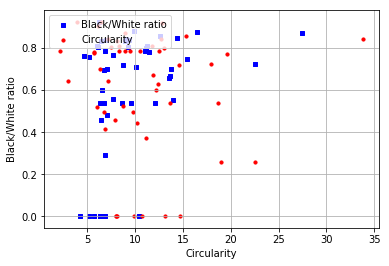

In [62]:
import numpy as np
import cv2
from scipy.misc import imread, imshow,face
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu

#test
img = Image("C:\\Users\\ThinkPad\\Downloads\\gti770\\data\\images\\231792.jpg","232031","smooth")

#plt.imshow(img.CroppedPixels)
#plt.title("original")
#plt.show()

#plt.imshow(img.GrayScale)
#plt.title("grayscale")
#plt.show()

print("threshold: ",img.Threshold)
#plt.imshow(img.Binary)
#plt.title("binarized")
#plt.show()

print("circularity: ", img.C)

print("black ",img.Black)
print("white ", img.White)
print("B/W ratio", img.BlackWhiteRatio)
#load
#sepration 70%-30% of the data set
trainDataSet = []
testDataSet = []

loadAllImages("C:\\Users\\ThinkPad\\Downloads\\gti770\\data\\csv\\galaxy\\galaxy_label_data_set.csv","C:\\Users\\ThinkPad\\Downloads\\gti770\\data\\images")

feature1x = []
feature1y = []
feature2x = []
feature2y = []
for ig in trainDataSet:
    if"smooth" in ig.Answer:
        feature1x.append(ig.BlackWhiteRatio)
        feature1y.append(ig.C)
    else:
        feature2x.append(ig.BlackWhiteRatio)
        feature2y.append(ig.C)
for ig in testDataSet:
    if"smooth" in ig.Answer:
        feature1x.append(ig.BlackWhiteRatio)
        feature1y.append(ig.C)
    else:
        feature2x.append(ig.BlackWhiteRatio)
        feature2y.append(ig.C)


traceGraph(feature1x,feature1y,"Black/White ratio",feature2x,feature2y,"Circularity")

Introduction et revue de la littérature

### Question 2

### Question 3

### Question 4

### Question 5

### Conclusion

### Bibliographie

In [214]:
https://docs.opencv.org/3.4.2/dd/d49/tutorial_py_contour_features.html

SyntaxError: invalid syntax (<ipython-input-214-1f74ff1184fd>, line 1)